In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
creditCardData = pd.read_csv('../input/creditcard.csv')

In [3]:
from sklearn.preprocessing import StandardScaler
creditCardData['normAmount'] = StandardScaler().fit_transform(creditCardData['Amount'].values.reshape(-1, 1))
creditCardData = creditCardData.drop(['Time','Amount'],axis=1)
creditCardData.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [4]:
X = creditCardData.iloc[:, creditCardData.columns != 'Class']
y = creditCardData.iloc[:, creditCardData.columns == 'Class']

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [6]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score,auc,precision_recall_curve,roc_curve

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def classification_eval(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    y_score = np.argmax(y_pred, axis=1)
    dec = np.int64(np.ceil(np.log10(len(y_test))))
    
    def plot_roc():
        fpr, tpr, t = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
        plt.plot([0,1],[0,1], 'k--', linewidth = 2)
        plt.xlim([0.0,0.001])
        plt.ylim([0.0,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (AUC=%0.2f)'% auc(fpr,tpr))
        plt.show();
    
    def plot_precision_recall():
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        plt.step(recall, precision, color = 'b', alpha = 0.2,where = 'post')
        plt.fill_between(recall, precision, step ='post', alpha = 0.2,color = 'b')
        plt.plot(recall, precision, linewidth=2)
        plt.xlim([0.0,1])
        plt.ylim([0.0,1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')
        plt.show();

    print('CONFUSION MATRIX')
    cfm=confusion_matrix(y_test, y_score)
    plot_confusion_matrix(cfm, classes = range(2)) 
    plt.show()
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_score, digits=dec))
    print('SCALAR METRICS')
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('Accuracy', accuracy_score(y_test, y_score)))
    plot_roc()
    plot_precision_recall()

In [9]:
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [10]:
sm = SMOTE(ratio='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs,input_shape=(n_inputs, ), activation='relu'),
    Dense(16, activation='relu'),
    Dense(16,activation='relu'),
    Dense(2, activation='softmax')
])
oversample_model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 318416 samples, validate on 79604 samples
Epoch 1/20
 - 2s - loss: 0.0690 - acc: 0.9767 - val_loss: 0.0194 - val_acc: 0.9963
Epoch 2/20
 - 2s - loss: 0.0106 - acc: 0.9977 - val_loss: 0.0055 - val_acc: 0.9994
Epoch 3/20
 - 2s - loss: 0.0064 - acc: 0.9989 - val_loss: 0.0041 - val_acc: 0.9998
Epoch 4/20
 - 2s - loss: 0.0049 - acc: 0.9991 - val_loss: 0.0071 - val_acc: 0.9978
Epoch 5/20
 - 2s - loss: 0.0043 - acc: 0.9993 - val_loss: 0.0019 - val_acc: 0.9995
Epoch 6/20
 - 2s - loss: 0.0038 - acc: 0.9994 - val_loss: 3.6442e-04 - val_acc: 1.0000
Epoch 7/20
 - 2s - loss: 0.0034 - acc: 0.9995 - val_loss: 0.0023 - val_acc: 0.9996
Epoch 8/20
 - 2s - loss: 0.0036 - acc: 0.9994 - val_loss: 8.4868e-04 - val_acc: 1.0000
Epoch 9/20
 - 2s - loss: 0.0032 - acc: 0.9995 - val_loss: 7.2288e-04 - val_acc: 1.0000
Epoch 10/20
 - 2s - loss: 0.0029 - acc: 0.9996 - val_loss: 3.3630e-05 - val_acc: 1.0000
Epoch 11/20
 - 2s - loss: 0.0031 - acc: 0.9996 - val_loss: 1.9104e-04 - val_acc: 1.0000
Epoch 12/20
 -

CONFUSION MATRIX


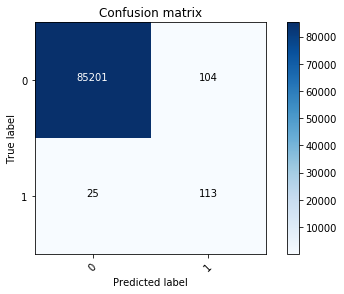

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99971   0.99878   0.99924     85305
           1    0.52074   0.81884   0.63662       138

   micro avg    0.99849   0.99849   0.99849     85443
   macro avg    0.76022   0.90881   0.81793     85443
weighted avg    0.99893   0.99849   0.99866     85443

SCALAR METRICS
     Accuracy = 0.99849


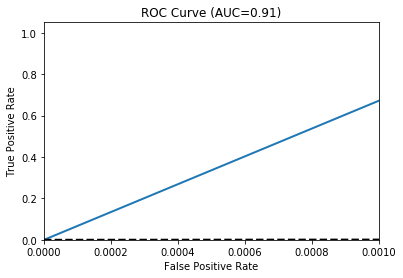

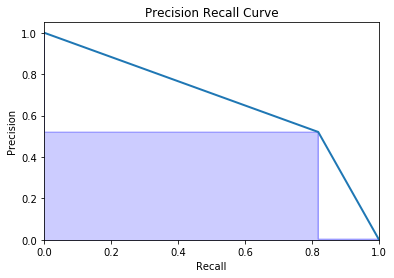

In [14]:
classification_eval(oversample_model, X_test, y_test)